In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
#import data
data = pd.read_csv('Generated Data/final_data.csv', encoding='utf-8')
delete_columns = ['Name','fail_count','Median response time','D11','Hatch Rate','Time', 'variant_cost_hr']
data = data.drop(delete_columns, axis=1)

In [3]:
def get_structured_data(data,label):
    #provides the final structured data for modeling 
    features = data.iloc[:,[x for x in range(10,24)]]
    target = data[label]
    structured_data = pd.concat([features, target], axis=1, sort=False)
    structured_data = remove_duplicates(structured_data)
    return structured_data

def remove_duplicates(data):
    data = data.drop_duplicates(subset=['request category','D1(Small), D2(Medium)', 'D3', 'D4', 'D5(Small)', 'D6(Large)', 'D7',
       'D8', 'D9', 'D10', 'D12(Small), D13(Medium)', 'D14', 'D15', 'D16'])
    return data


## Feature Selection

In [16]:
#Train-test split
structured_data =  get_structured_data(data, "mean_rt")

X = structured_data.iloc[:, 0:14]  #Feature Matrix
y = structured_data.iloc[:, -1] #Target Variable


In [15]:
#Base Model
def base_DTR(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    base_DTR = DecisionTreeRegressor()
    base_DTR.fit(X_train, y_train)

    #Score
    y_predicted = base_DTR.predict(X_test)
    r2_score_x = r2_score(y_test, y_predicted)
    print('R-Square: ', r2_score_x)
    print('MSE: ', mean_squared_error(y_test,y_predicted))
base_DTR(X,y)

R-Square:  0.7807941280229136
MSE:  17367294.866666667


### Backward elimination

#### Selected Choice!

In [63]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['request category', 'D1(Small), D2(Medium)', 'D3', 'D4', 'D6(Large)', 'D7', 'D8']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Decision Tree Regressor

In [64]:
def param_tuningDTR(X,y):
    #returns the best params
    crit = []
    spli = []
    dep = []
    r2scr = []
    r2scr_nrn = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)


    dept_df = pd.DataFrame()
    dept_df['y'] = y_test.to_list()
 
    criterion = ['mse','friedman_mse','mae']
    for cr in criterion:
        split = ['random', 'best']
        for sp in split:
            depth = [2,4,6,8,10]
            for m in depth:

                mlregr = DecisionTreeRegressor(criterion=cr, splitter=sp, max_depth=m, max_features='auto')
                mlregr.fit(X_train, y_train)

                #Score
                model_score = mlregr.score(X_train,y_train)
                y_predicted = mlregr.predict(X_test)
                crit.append(cr)
                spli.append(sp)
                dep.append(m)
                r2_score_x = r2_score(y_test, y_predicted)
                r2scr.append(r2_score_x)
                dept_df["depth("+str(m)+")"] = y_predicted.tolist()

    history = pd.DataFrame(list(zip(crit, spli, dep, r2scr)), 
                   columns =['criterion', 'splitter', 'max_depth', 'r2_score'])
    best_params = history.iloc[history['r2_score'].idxmax()]
    
    return best_params, dept_df, depth

In [65]:
def trainsize_gridsearch(X, y, best_params):
    
    scores = []
    sizes = [0.1,0.2,0.3,0.4,0.5]

    for size in sizes:
        XX_train, XX_test, yy_train, yy_test = train_test_split(X, y, test_size=size, random_state=42)

        mlregr_final = DecisionTreeRegressor(criterion=str(best_params[0]), splitter=best_params[1], max_depth=best_params[2], 
                                             max_features='auto')
        mlregr_final.fit(XX_train, yy_train)

        #Score
        model_score = mlregr_final.score(XX_train, yy_train)
        y_pred = mlregr_final.predict(XX_test)
        scores.append(round(r2_score(yy_test, y_pred),2))
    size_score = pd.DataFrame(list(zip([1-s for s in sizes], scores)), columns=['train_size','r2_score'])
    
    return size_score

In [74]:
best_params, dept_df, depth = param_tuningDTR(X,y)
size_score = trainsize_gridsearch(X, y, best_params)
size_score = size_score.iloc[size_score['r2_score'].idxmax()]
best_train_size = round(1-size_score[0],2)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_train_size, random_state=42)
mlregr_final = DecisionTreeRegressor(criterion=str(best_params[0]), splitter=best_params[1], max_depth=int(best_params[2]), 
                                         max_features='auto')
mlregr_final.fit(X_train, y_train)

#Score
model_score = mlregr_final.score(X_train, y_train)
y_pred = mlregr_final.predict(X_test)

print("Model Score: ", round(model_score,2))
print("R-squared score: ", round(r2_score(y_test,y_pred),3))

Model Score:  1.0
R-squared score:  0.843


In [76]:
print("Fine tuned Parameters:\n ",mlregr_final.get_params)

Fine tuned Parameters:
  <bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')>


In [69]:
#Visualize DTR  model tree
# dot_data = StringIO()
# export_graphviz(mlregr_final, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

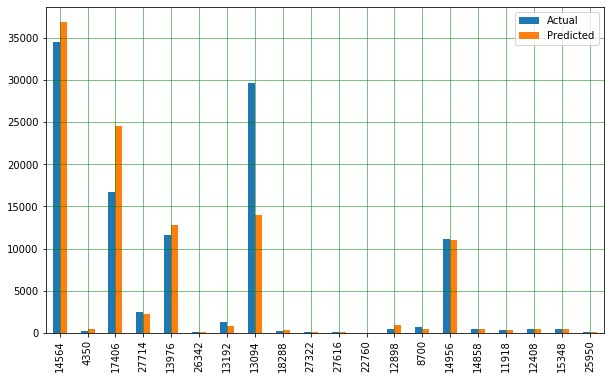

In [77]:
y_pred = mlregr_final.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df1 = df.head(20)
df1.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

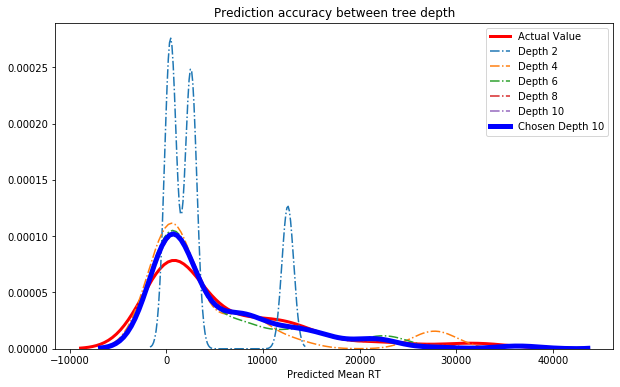

In [78]:
plt.figure(figsize=(10,6))
ax1 = sns.distplot(dept_df['y'], hist=False, color='r', kde_kws={'linewidth':3},  label="Actual Value", )

for x in depth:
    sns.distplot(dept_df["depth("+str(x)+")"], hist=False, kde_kws={'linestyle':'-.'}, label="Depth "+str(x))
sns.distplot(dept_df["depth("+str(int(best_params[2]))+")"], hist=False, color='b', kde_kws={'linewidth':5}, label="Chosen Depth "+str(int(best_params[2])))
plt.xlabel("Predicted Mean RT")
plt.ylabel("")
plt.title('Prediction accuracy between tree depth')
#plt.savefig("DTR_depth.png")
plt.show()